# Advanced Lane Finding Project
The goals / steps of this project are the following:
1. Correct Image Distortion: a) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images, b) Apply a distortion correction to raw images.
2. Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find the lane boundary.
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## 1. Correct Image Distortion
Correction of image distortion (created by the camera) is done in 2 steps:
a) calculate cameral matrix and distortion coefficients and
b) undistort an image using statistics calculated in the step a.

The first step was implemented in a utility class src/CameraCallibration.py. The script in aforementioned file processed all provided examples (chessboard images) and stored resulting stats in src/calibration.p. Therefore, in this book we will focus on the step b).

Step b) consists of creating an CameraCalibration object and using this object to undistort an image. The code for this step provided in the cell below.

In [20]:
import cv2
import numpy as np
from src.CameraCalibration import CameraCalibration as CC
from matplotlib import pyplot as plt
from src.utils import visualize_planes
%matplotlib inline
# Create camera calibration object
calibration_file = "src/calibration.p"
cc = CC(calibration_file)
# Read and undistort an image
test_img_path1 = "test_images/straight_lines2.jpg"
test_img_path2 = "test_images/test3.jpg"
test_img1 = cv2.cvtColor(cv2.imread(test_img_path1), cv2.COLOR_BGR2RGB)
test_img2 = cv2.cvtColor(cv2.imread(test_img_path2), cv2.COLOR_BGR2RGB)
undistorted_img1 = cc.undistort(test_img1, 1)
undistorted_img2 = cc.undistort(test_img2, 1)
undistorted_cropped_img1 = cc.undistort(test_img1)
undistorted_cropped_img2 = cc.undistort(test_img2)

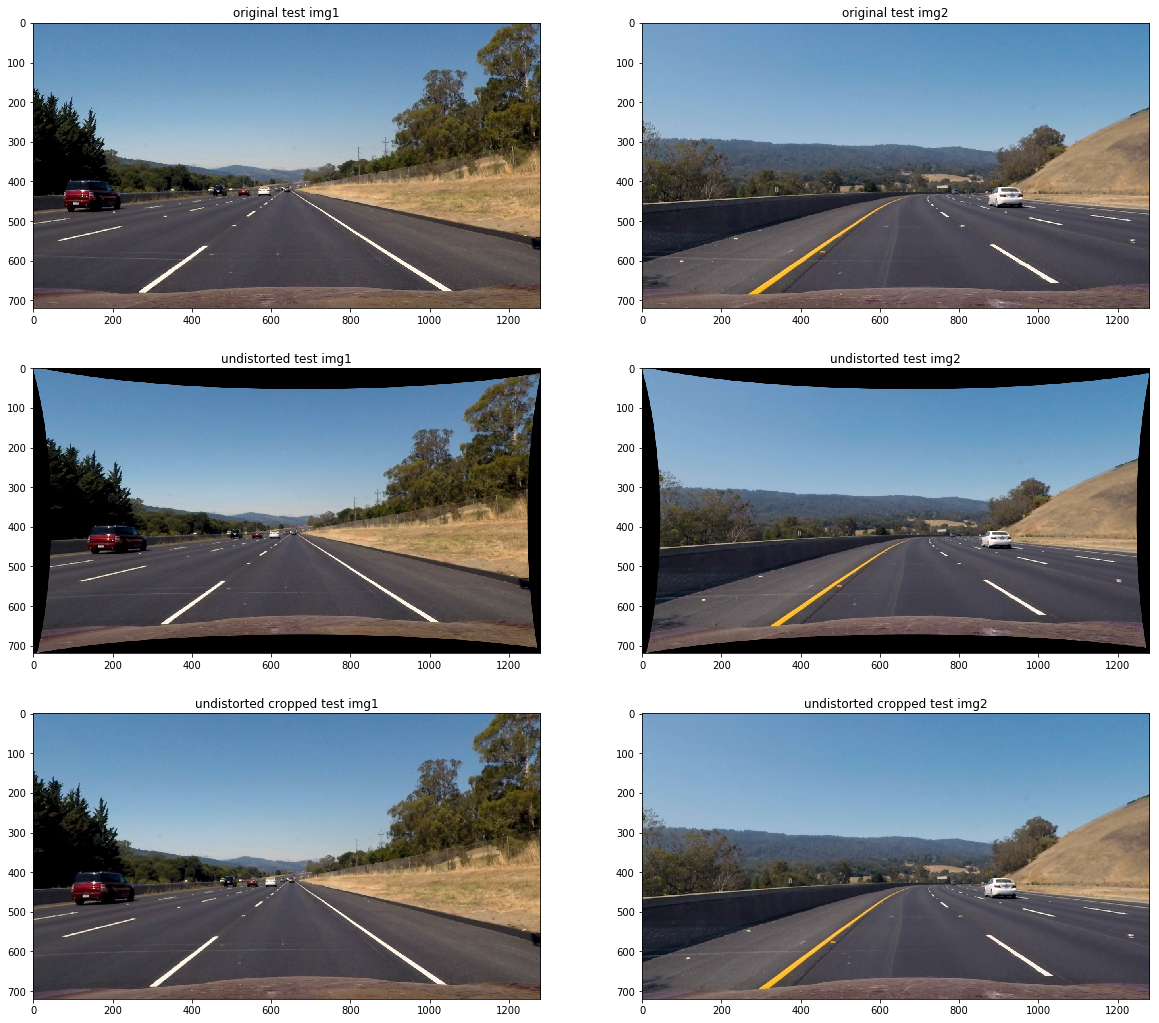

In [21]:
# Visualize resulting images
f, p = plt.subplots(3, 2, figsize=[20,18])
p[0][0].set_title("original test img1")
p[0][0].imshow(test_img1)
p[1][0].set_title("undistorted test img1")
p[1][0].imshow(undistorted_img1)
p[2][0].set_title("undistorted cropped test img1")
p[2][0].imshow(undistorted_cropped_img1)
p[0][1].set_title("original test img2")
p[0][1].imshow(test_img2)
p[1][1].set_title("undistorted test img2")
p[1][1].imshow(undistorted_img2)
p[2][1].set_title("undistorted cropped test img2")
p[2][1].imshow(undistorted_cropped_img2)

## 2. Use color transforms, gradients, etc., to create a thresholded binary image
Second step includes a raw image transformation into a binary masks by applying conditions to processed image. The image processing step relies on the conversion of the raw image into either a combination of x and y Sobel gradients or using a particular color channel or combination of all.

The code below presents functions allowing to conver your raw images into binary masks.

In [22]:
from src.utils import abs_sobel_thresh, mag_thresh, dir_threshold

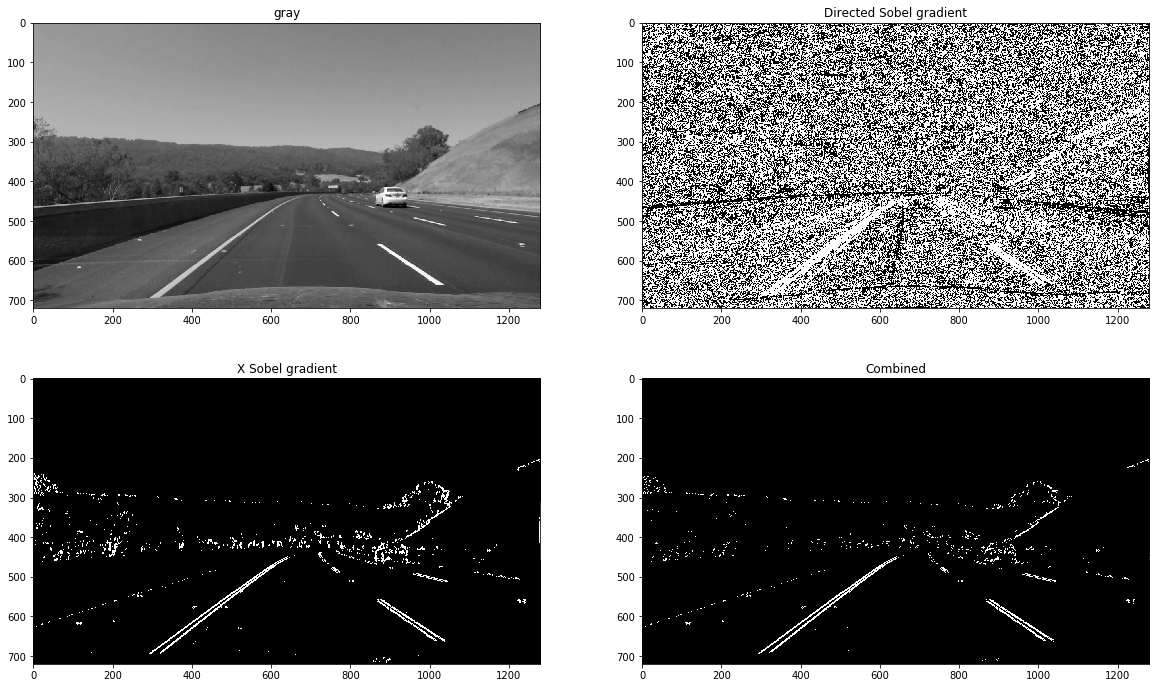

In [23]:
# Convert to grayscale
gray = cv2.cvtColor(undistorted_cropped_img2, cv2.COLOR_RGB2GRAY)
# Transform and visualize images
sobel_x_img = abs_sobel_thresh(gray, orient='x', kernel=7, thresh=(30, 150))
direct_sobel_img = dir_threshold(gray, kernel=7, thresh=(30*np.pi/180, 80*np.pi/180))
combined = np.zeros_like(sobel_x_img, dtype=np.uint8)
combined[(sobel_x_img==1) & (direct_sobel_img==1)] = 1
f, p = plt.subplots(2,2, figsize=[20, 12])
p[0,0].set_title("gray")
p[0,0].imshow(gray, cmap='gray')
p[1,0].set_title("X Sobel gradient")
p[1,0].imshow(sobel_x_img, cmap='gray')
p[0,1].set_title("Directed Sobel gradient")
p[0,1].imshow(direct_sobel_img, cmap='gray')
p[1,1].set_title("Combined")
p[1,1].imshow(combined, cmap='gray')

Based to the results presented above, Sobel gradient with x orientation is a good starting point. However, additional condition set for the direction of the gradient helps to remove some of the noice from the middel part of the image. 

However, to ensure that the algorithm delivers good results on all images it is important to stest the performance on a harder cases. The example below demostrates the shortcomings of gray scale images processed with Sobel gradient

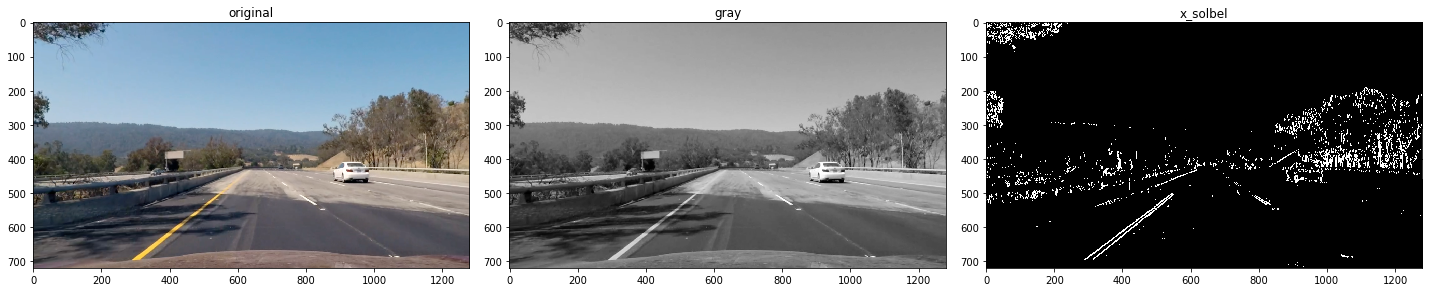

In [24]:
bridge = cc.undistort(cv2.cvtColor(cv2.imread('test_images/bridge.png'), cv2.COLOR_BGR2RGB))
bridge_gray = cv2.cvtColor(bridge, cv2.COLOR_RGB2GRAY)
bridge_sobel = abs_sobel_thresh(bridge_gray, orient='x', kernel=7, thresh=(30, 150))
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(['original','gray','x_solbel'][i])
    plt.imshow([bridge, bridge_gray, bridge_sobel][i], cmap='gray') if i>0 else plt.imshow([bridge, bridge_gray, bridge_sobel][i])
plt.tight_layout()

As you can see on the top left side of the road, due to gray scale conversion we lost important color information. In gray scale the top left side of the road has very similar color. As a result we will lose the tack of the lanes in this segment.

In order to mitiage this problem, we should explore information contained in color channels. In order to capture color information, I will convert raw image into hsl image to validate which of the channels provies the best features for lane detection.

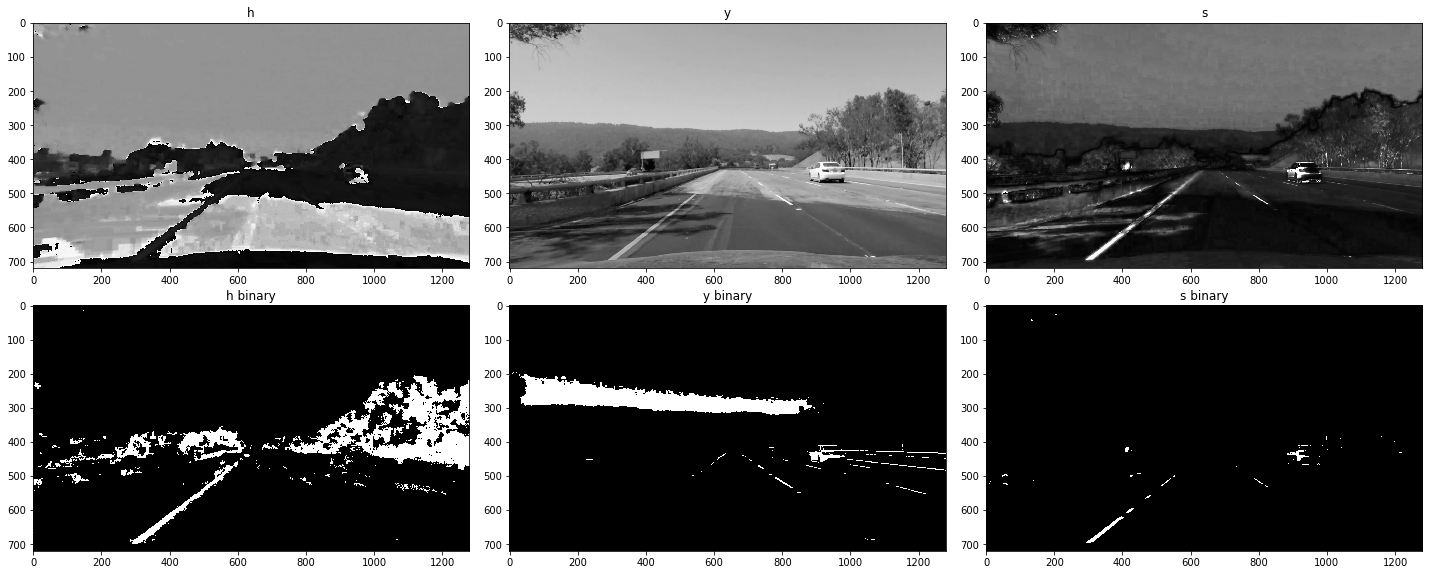

In [25]:
img = bridge
h,l,s = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HLS))
y, _, _ = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YUV))
hb = np.zeros_like(h, dtype=np.uint8)
hb[(h>=16) & (h<24)] = 255
yb = np.zeros_like(y, dtype=np.uint8)
yb[(y>=200) & (y<255)] = 255
sb = np.zeros_like(s, dtype=np.uint8)
sb[(s>=200) & (s<=255)] = 255
plt.figure(figsize=(20,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title(["h","y","s","h binary", "y binary", "s binary"][i])
    plt.imshow([h,y,s,hb,yb,sb][i], cmap="gray")
plt.tight_layout()

As you can see on the images on the left, H channel provides an important information related to color. This information allows us precisely identify left lane. S (saturation) channel also seem to be useful. However, S channel emperically proved to be more expose to noice intoduced by shadows.

Another important finding is that y channel of YUV color scheme can be helpful to threshold white lanes.

As a result, I settle on a combination of H and Y channel to filter yellow and white lane lines (result presented below)

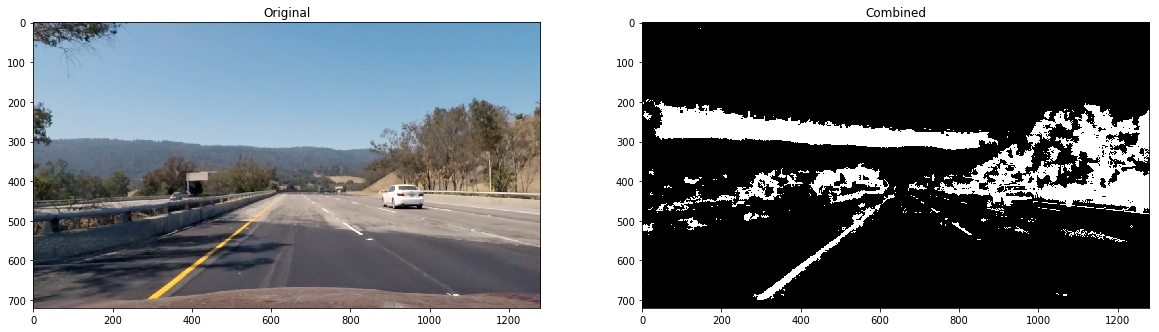

In [26]:
# Transform and visualize images
combined = np.zeros_like(y, dtype=np.uint8)
combined[(hb==255) | (yb==255)] = 255
f, p = plt.subplots(1,2, figsize=[20, 12])
p[0].set_title("Original")
p[0].imshow(bridge)
p[1].set_title("Combined")
p[1].imshow(combined, cmap='gray')

## 3. Apply a perspective transform to rectify binary image ("birds-eye view").

To apply a perspective transform I first calculated the coordinates for rectangle that describes the plane on a source (src) and desired image (dst). Then, I created a transformation matrix (cv2.getPerspectiveTransform) and applied this matrix to the image (cv2.warpPerspective).

The transformation script and result of the transformation are presented below:

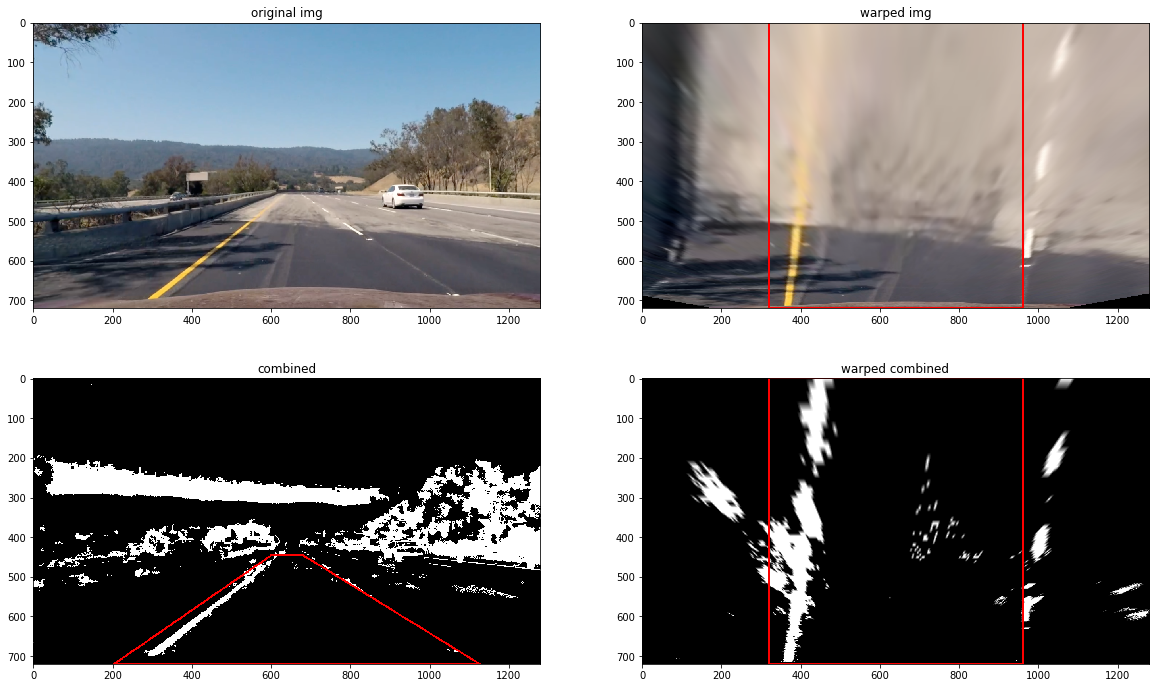

In [27]:
from src.utils import warper

top_c_shift = 39
top_v_shift = 85

rgb_combined = np.dstack([combined, combined, combined])
warped_combined, (src, dst) = warper(rgb_combined, top_c_shift=top_c_shift, top_v_shift=top_v_shift)
rgb_combined = visualize_planes(rgb_combined, src)
warped_combined = visualize_planes(warped_combined, dst)
warped_img, (src, dst) = warper(img)
undistorted_cropped_img2 = visualize_planes(undistorted_cropped_img2, src)
warped_img = visualize_planes(warped_img, dst)

fig, p = plt.subplots(2,2, figsize=[20,12])
p[0,0].set_title("original img")
p[0,0].imshow(img)
p[0,1].set_title("warped img")
p[0,1].imshow(warped_img)
p[1,0].set_title("combined")
p[1,0].imshow(rgb_combined)
p[1,1].set_title("warped combined")
p[1,1].imshow(warped_combined)

## 4. Detect lane pixels and fit to find the lane boundary

In order to detect lane pixels I applied a sliding window method. Sliding window method divides the images into n windows. The maximum activations found in each window considered to be the centers of the lane or centorid. Therefore, binary active pixels sournding this centroid will be considered belonging to the lane.

The method of finding centroids described in map_window method of src/utils.py

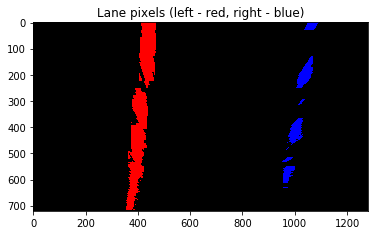

In [29]:
from src.utils import find_window_centroids, map_window
combined, (src, dst) = warper(combined, top_c_shift=top_c_shift, top_v_shift=top_v_shift)
centroids = find_window_centroids(combined, 61, 120, 100)
l_pixels, r_pixels = map_window(combined, centroids, 61, 120)
left_pixels = np.zeros_like(combined, dtype=np.uint8)
left_pixels[l_pixels]=255
right_pixels = np.zeros_like(combined, dtype=np.uint8)
right_pixels[r_pixels]=255
mapped_lane = cv2.merge((left_pixels, np.zeros_like(combined, dtype=np.uint8), right_pixels))
plt.imshow(mapped_lane)
plt.title("Lane pixels (left - red, right - blue)")

## 5. Determine the curvature of the lane and vehicle position with respect to center.

To calculate the curvature I applied the formula below:

R(f(y)) = (1+f(y)'^2)^(2/3) / |f(y)''|, where:

* f(y) = A*y^2 + B*y + C
* f(y)' = 2Ay + B
* f(y)'' = 2A

Therefore:

R(f(y)) = (1+(2Ay+B)^2)^(2/3) / |2A|

The results are presented below:

In [32]:
from src.utils import fit_polynomial, plot_2nd_degree_polynomial

R = lambda M, y: (1+(2*M[0]*y+M[1])**2)**(2/3) / np.abs(2*M[0])

x_scaller = 3.7 / 580
y_scaller = 8.5*3 / 720

left_x, left_y = plot_2nd_degree_polynomial(centroids[:, 0], combined.shape[0])
right_x, right_y = plot_2nd_degree_polynomial(centroids[:, 1], combined.shape[0])

left_fit = fit_polynomial(centroids[:, 0], combined.shape[0], x_scaller=x_scaller, y_scaller=y_scaller)
right_fit = fit_polynomial(centroids[:, 1], combined.shape[0], x_scaller=x_scaller, y_scaller=y_scaller)

left_curve_rad = R(left_fit, left_y).mean()
right_curve_rad = R(right_fit, right_y).mean()

print("Left radius in meters: {:.1f}".format(left_curve_rad))
print("Right radius in meters: {:.1f}".format(right_curve_rad))

Left radius in meters: 8139.3
Right radius in meters: 1802.2


## Last step - processing video

In [10]:
from src.Advanced_Path_Finding import APF
from moviepy.editor import VideoFileClip

path_to_video = 'project_video.mp4'
path_to_save = 'output_images/project_video.mp4'

apf = APF(calibration_file_path='src/calibration.p', frames=2,
          h_threshold=(16, 24), y_threshold=(200, 256), direction_threshold=(0.0, 1/6 * np.pi),
          sobel_window=(61, 120, 60), sobel_kernel=9)

def img_processing(img, size=()):
    try:
        resulting_img, _ = apf.detect(img, debug=False)
    except:
        resulting_img = img
    return resulting_img

clip = VideoFileClip(path_to_video)
line_detection_clip = clip.fl_image(img_processing)
%time line_detection_clip.write_videofile(path_to_save, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [05:39<00:00,  3.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 6min 2s, sys: 55 s, total: 6min 57s
Wall time: 5min 40s
